# TASK 1 - Description

Our first task will be to prepare an experimentally motivated ordered state consisting of alternating ground and Rydberg states in a one-dimensional (1D) chain, the so-called 
 state:
To get us started, we will use the open-source simulation software Bloqade to prepare the 
 state of a one-dimensional chain of 9 atoms with open boundary conditions. In order to prepare this state, follow the Bloqade tutorial: generate the pulse/detuning sequence, specify the atomic position, then starting in the groundstate, simulate the time evolution of a quantum state under the Schrödinger equation.
Plot the average occupation on each site as a function of time.

In addition, calculate the expectation value of 
 and gap 
 between the Rydberg Hamiltonian's groundstate and first excited state. What does the latter imply about the viability of the adiabatic protocol for this type of quantum computer? Can you determine how it scales with increasing array size?

In [99]:
# Imports 

using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

plt = pyimport("matplotlib.pyplot");

# Define lattice

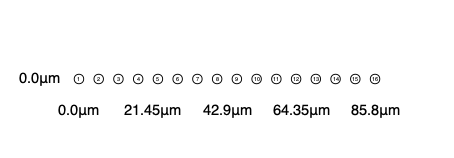

In [100]:
nsites = 16
atoms = generate_sites(ChainLattice(), nsites, scale = 5.72)

# Tuning protocol - linear

In [101]:
total_time = 3.0;
Ω_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Ω_max, Ω_max, 0, 0]);

In [102]:
U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

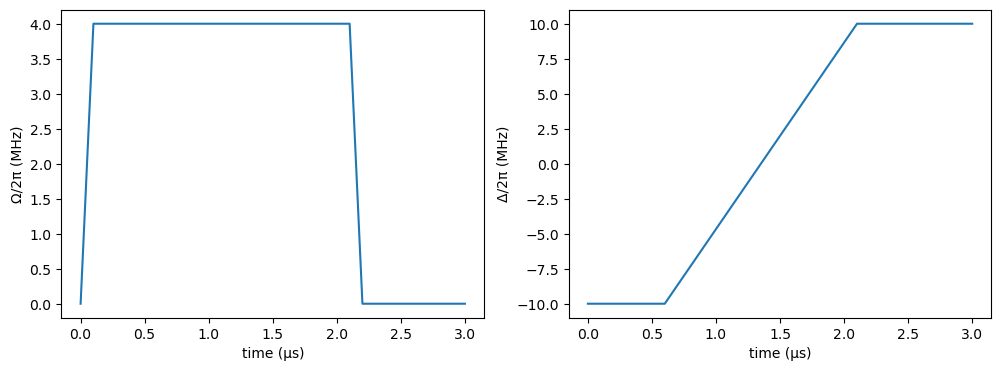

In [103]:
# parameters tuning protocol plot

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

# Define Hamiltonian 

In [104]:
h = rydberg_h(atoms; Δ, Ω)

nqubits: 16
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


# Define the state and evolve under the Hamiltonian

In [105]:
reg = zero_state(nsites);
prob = SchrodingerProblem(reg, total_time, h);
integrator = init(prob, Vern8());

In [106]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

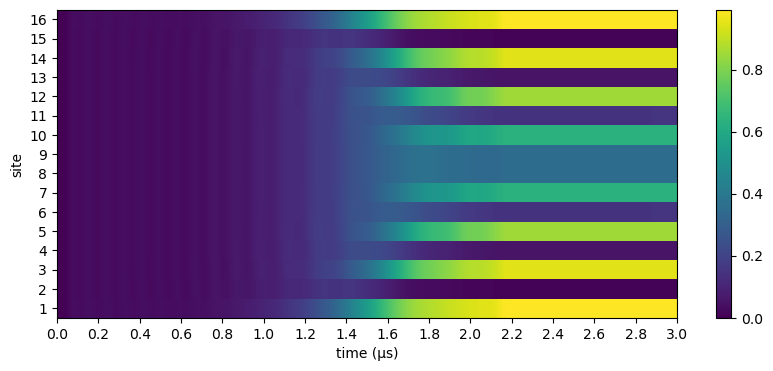

In [107]:
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

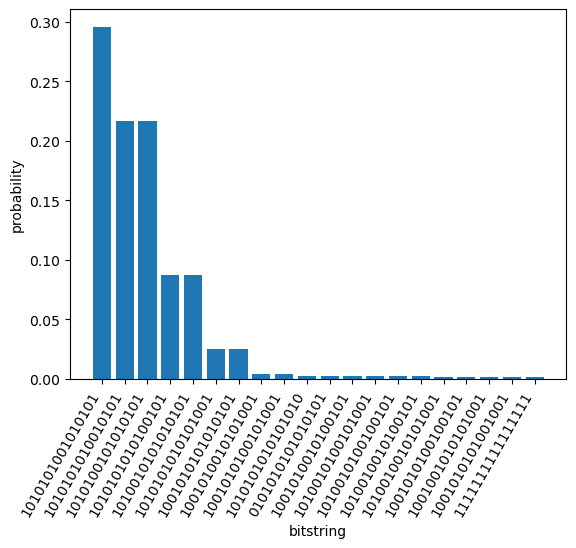

In [108]:
bitstring_hist(reg; nlargest = 20)

# Tuning protocol - smooth

In [109]:
# Total time of pulses
t_time = 3.0

# Rabi friequency
omega = 2π * 4.0

# Detuning amplitude
d = 2π * 15.0

94.24777960769379

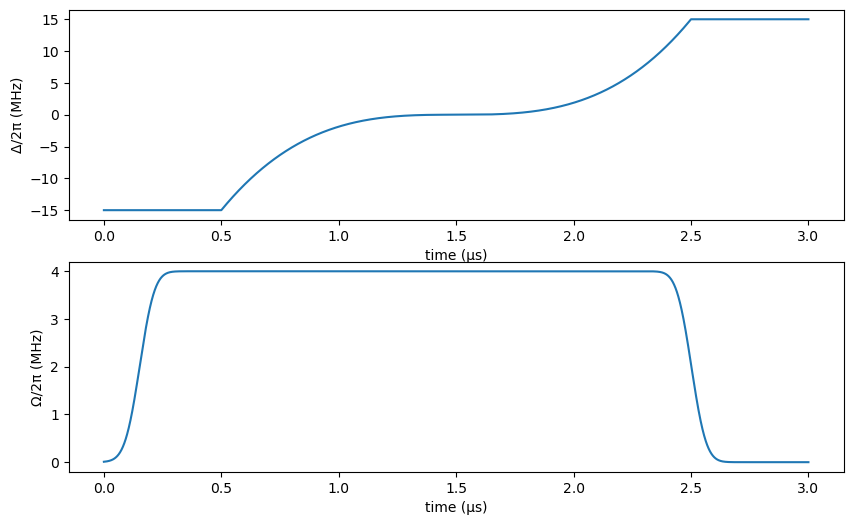

In [110]:
# Cubic delta waveform
A = d / ((t_time - 1) / 2)^3
delta_t = Waveform(t -> A * (t - (t_time - 1)/ 2)^3, duration=t_time - 1)
delta_t = append(constant(duration=0.5, value=-d), delta_t)
delta_t = append(delta_t, constant(duration=0.5, value=d))

# Omega waveform
omega_t = piecewise_constant(clocks=[0.0, 0.05 * t_time, t_time - 0.5, t_time], values = [0.0, omega, 0.0])
omega_t = smooth(omega_t; kernel_radius=0.05)

fig, (ax1, ax2) = plt.subplots(nrows = 2, figsize = (10, 6))
Bloqade.plot!(ax1, delta_t)
ax1.set_ylabel("Δ/2π (MHz)")
Bloqade.plot!(ax2, omega_t)
ax2.set_ylabel("Ω/2π (MHz)")
fig

# Define Hamiltonian

In [111]:
h = rydberg_h(atoms; Δ = delta_t, Ω = omega_t)

nqubits: 16
+
├─ [+] ∑ 2π ⋅ 8.627e6.0/|r_i-r_j|^6 n_i n_j
├─ [+] Ω(t) ⋅ ∑ σ^x_i
└─ [-] Δ(t) ⋅ ∑ n_i


# Evolve the state under the Hamiltonian with smooth parameter change 

In [112]:
reg = zero_state(16);
prob = SchrodingerProblem(reg, t_time, h);
integrator = init(prob, Vern8());

In [113]:
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...);

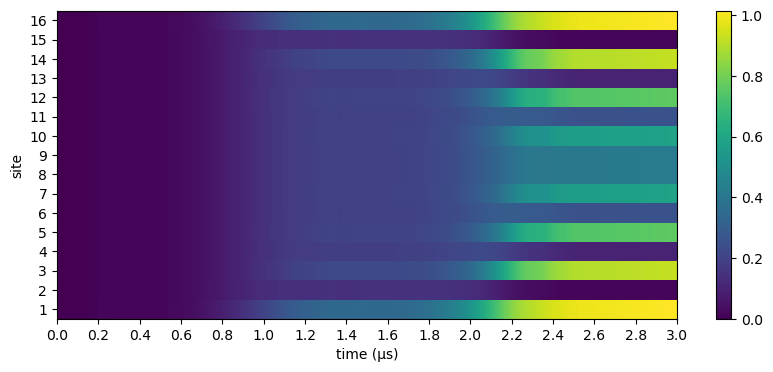

In [114]:
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:t_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

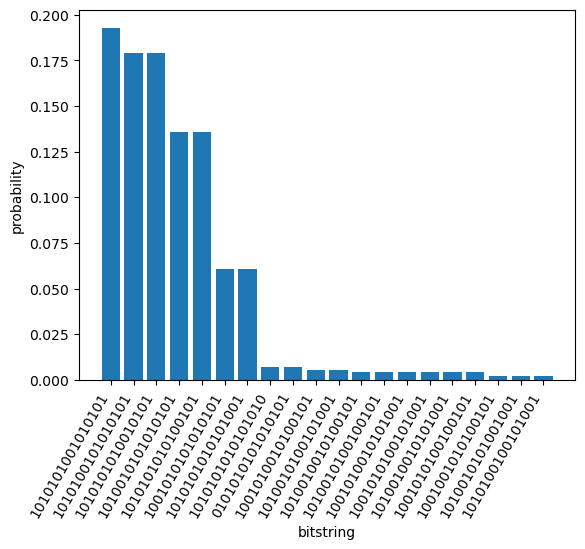

In [115]:
bitstring_hist(reg; nlargest = 20)

# Sigma X expectation

In [42]:
# Expectation for sigma_x
sigma_x_expectation = []
for i in 1:nsites
    push!(sigma_x_expectation,expect(put(nsites, i => X), reg))
end
sigma_x = hcat(sigma_x_expectation...);

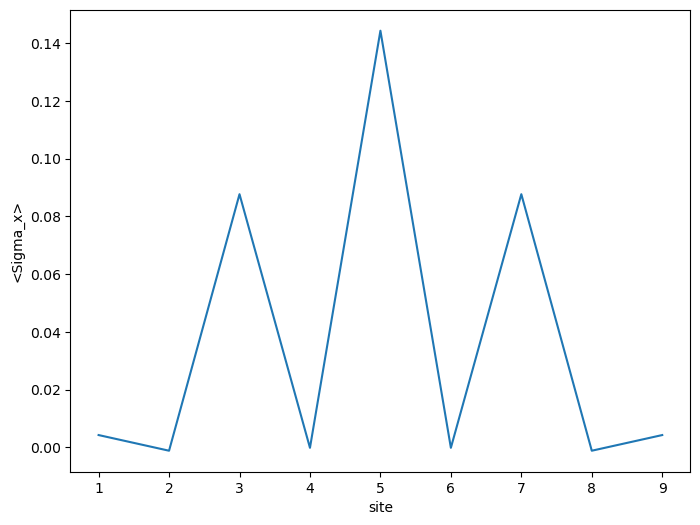

In [65]:

fig, (ax) = plt.subplots(ncols = 1, figsize = (8, 6))
ax.plot([1,2,3,4,5,6,7,8,9],real(transpose(sigma_x)))


ax.set_xlabel("site")
ax.set_ylabel("<Sigma_x>")

fig

# Energy gap scaling 

In [76]:
energy_gap = []

for i in 1:5
    atoms = generate_sites(ChainLattice(), 4 * i, scale = 5.72)
    # Diagonilization of time-independent Hamiltonian
    h_c = rydberg_h(atoms; Δ=U2, Ω=Ω_max)
    h_m = mat(h_c)
    vals, vecs, info = KrylovKit.eigsolve(h_m,  2, :SR)
    push!(energy_gap, vals[2] - vals[1])
    
end

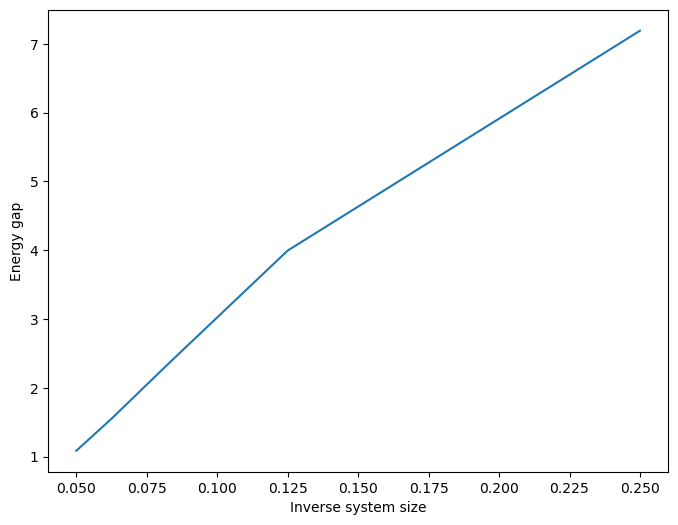

In [78]:
fig, (ax) = plt.subplots(ncols = 1, figsize = (8, 6))
ax.plot([1/4,1/8,1/12,1/16, 1/20],energy_gap)


ax.set_xlabel("Inverse system size")
ax.set_ylabel("Energy gap")

fig